# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [26]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re as re
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [136]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
        
    # clean comment texts
    # 1. remove '\\n'
    toxic_data['comment_text'] = toxic_data['comment_text'].map(lambda x: re.sub('\\n',' ',str(x)))
    
    # 2. remove texts starting with 'User ...'
    toxic_data['comment_text'] = toxic_data['comment_text'].map(lambda x: re.sub("\[\[User.*",'',str(x)))
    
    # 3. remove IP addresses or user IDs
    toxic_data['comment_text'] = toxic_data['comment_text'].map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    
    # 4. remove http links in texts
    toxic_data['comment_text'] = toxic_data['comment_text'].map(lambda x: re.sub("(http://.*?\s)|(http://.*)",'',str(x)))
    
    print("the first 5 rows of data after cleaning comment texts:")
    print(toxic_data.head(5))
    
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['new_line'] = toxic_data['comment_text'].str.count('\n' * 1)
    toxic_data['exclam_count'] = toxic_data['comment_text'].str.count("!")
    toxic_data['question_count'] = toxic_data['comment_text'].str.count("\?")
    print("Current Data:")
    print(toxic_data.head(5))
    

    X_quant_features = toxic_data[["word_count", "punc_count", "new_line", "exclam_count", "question_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(20))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)
  

# Create training and test sets from function

In [137]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='toxiccomments_train.csv', my_random_seed=99)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))


toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [109]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13036, 'Neg': 114620, 'TP': 6694, 'TN': 59811, 'FP': 54809, 'FN': 6342, 'Accuracy': 0.5209704205051074, 'Precision': 0.10884021917630034, 'Recall': 0.5135010739490641, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [110]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13036, 'Neg': 114620, 'TP': 12931, 'TN': 114519, 'FP': 101, 'FN': 105, 'Accuracy': 0.9983862881494016, 'Precision': 0.9922498465316145, 'Recall': 0.9919453820190243, 'desc': 'svm_train'}


### MODEL: logistic regression

In [111]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13036, 'Neg': 114620, 'TP': 12973, 'TN': 114574, 'FP': 46, 'FN': 63, 'Accuracy': 0.9991461427586639, 'Precision': 0.9964667025117137, 'Recall': 0.9951672292114145, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [112]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13036, 'Neg': 114620, 'TP': 12788, 'TN': 103263, 'FP': 11357, 'FN': 248, 'Accuracy': 0.9090916212320611, 'Precision': 0.5296334644854007, 'Recall': 0.9809757594354096, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [113]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13036, 'Neg': 114620, 'TP': 12969, 'TN': 114512, 'FP': 108, 'FN': 67, 'Accuracy': 0.9986291282822586, 'Precision': 0.9917412250516173, 'Recall': 0.9948603866216631, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [114]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 13036, 'Neg': 114620, 'TP': 11029, 'TN': 114443, 'FP': 177, 'FN': 2007, 'Accuracy': 0.9828915209625869, 'Precision': 0.9842048902373728, 'Recall': 0.8460417305922062, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [115]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/Users/yiran/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 13036, 'Neg': 114620, 'TP': 0, 'TN': 114620, 'FP': 0, 'FN': 13036, 'Accuracy': 0.8978818073572726, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/Users/yiran/Desktop/ml/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

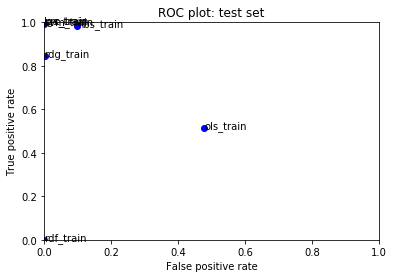

In [116]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [117]:
ols_predictions = ols.predict(X_train)

In [118]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
29
"::Hi, Vic. No probs. I'm not on my laptop atm but I'll send the PDF to you as soon as I get back home (Monday night, Tuesday morning tops). Sorry about the late reply – I've been stuck in this bloody country house in the middle of nowhere since Tuesday, wireless connection breaking up all the time and on someone else's mobile. Nightmare. Say hi to Ceoil for me. Cheers,  (talk)  PS, I've trawled through my inbox and no epistle from a Miss Earle. May be it ended up in the spam folder.  "
* * * * * * * * * 
184
The tree in the photo at the link Gregory Wonderwheel posted is a Chinese Juniper. Calling it a cedar is a mis-translation -
* * * * * * * * * 
308
I totally reject number 4 and will not agree to something along those lines.
* * * * * * * * * 
346
Canvassing   Regarding your recent posting on my talk page,  please read WP:CANVASS.
* * * * * * * * * 
404
Yeh Rishta Kya Kehlata Hai page   I fixed the picture on the page by adding a source. I just want

3642
Hi Jamie,  Could you advise me on how to post information regarding legitimate case studies in a manner that doesn't seem like i am promoting a company?
* * * * * * * * * 
3658
X talk at Google   Just watched this. Good one! And I'm pleased the Wikipedia reconstruction of X circa 1990 was accurate enough to use ;-) -
* * * * * * * * * 
3673
" If you wish to have your block reviewed, it might be helpful to inform us as to why you thought this edit was constructive.  t/c "
* * * * * * * * * 
3675
Maybe you misunderstand - the pronunciation of 'X' in Spanish makes a sound like the sound a kiss makes - not the Spanish word that means 'kiss' - see onomatopoeia ?
* * * * * * * * * 
3692
{{unblock | reason=I am sincerely sorry that I made personal attacks on other users. I now see that I do not own pages and if I disagree with a users edit, I should use the talk pages to discuss the matter in a constructive manner. I apologize to the users, admins and readers that I have disrespected. I 

6374
"   Veganism   I noticed your comments on Woohookitty's talk page. Thank you for your efforts. I've also noticed your comments on the Veganism talk page. While your points are valid, you seem to be phrasing them along with personal attacks. Please review the policy, at Wikipedia:No personal attacks. It's interpreted incredibly loosely, and can be twisted to fit anything. Notice that I'm not mentioning any names. That alone is a major help.   You would be doing me a big favor if you would create a stable account, and use it, especially if you don't have a fixed IP, as you stated on Woohookitty's talk page. I'm trying to keep Veganism clean and neutral while maintaining validity. Especially now that  has decided to attempt to develop an RfC ""against"" me, it would be in my best interests for you to develop a unique, fully-independant Account. Just to make things damned clear. I can't give them an inch. Again, thank you for your efforts.  "
* * * * * * * * * 
6396
Your condescending

9403
Coal scrip/Company Scrip   I agree with the move and yes, with the current content of the scrip article. I however have a slight contention with the idea of an area being cash poor. At first, YES, the areas were remote and yes, were in some cases cash poor. HOWEVER it is not a universal characteristic. The example would be the coal scrip I posted from Hot Coal West Virginia. The winding gulf bank resided at Hot Coal for many years before moving to the city of Beckley. How can a place be cash poor, if a bank resides in its immediate limits??
* * * * * * * * * 
9418
"::*Also, Boller reports that the wife of a political foe called Buchanan ""Old Gurley"" as a slur regarding his effeminate features. I don't think we have the space to report every name that someone called either Buchanan or King in the article, as it tends to lend undue weight to the insults, in my view.  "
* * * * * * * * * 
9435
"Suggest move to Ieper on the basis that that is its Flemish language name.  The argument

MfD nomination of User:NewOneLike/sandbox . Your opinions on the matter are welcome; please participate in the discussion by adding your comments at Wikipedia:Miscellany for deletion/User:NewOneLike/sandbox  and please be sure to sign your comments with four tildes (~~~~).  You are free to edit the content of
* * * * * * * * * 
12313
Having fun? Another of your racist admins just deleted my response again and u keep lying about me.
* * * * * * * * * 
12345
"  I see no problem with those sources, unless 1) is defamatory or 3) is contradicted by another source. | talk  "
* * * * * * * * * 
12392
"  The biggest conflict of interest is that she has had a personal email relationship and she is angry about something else.  For diffs on an earlier dispute, I would have to get them from her talk page, around middle of March of this year.  I will get you diffs from my talk page now.  Please wait.Malke2010 "
* * * * * * * * * 
12419
I'm afraid that obvious misinformation must be corrected whatev

15025
"   Tabib's POV is not a NPOV  Tabib is pushing Azeri-Turkish propaganda, calling it NPOV. All his opponents are taged with a ""vandal"" label. This person just cannot accept other opinions, which are different with his own. He is not able and not willing to compromise or nagotiate anything."
* * * * * * * * * 
15107
Arts lists   Hi, I saw your post to caravaggisti & have linked a couple & will do more later. Is it ok to add new missing ones, many of which are not on yours - I have my own little missing list? I don't have the encyclopedia refs. I notice lots of yours use a full 3 names where WP does/would only use 2, so I suspect there are many others that actually have articles.  cheers
* * * * * * * * * 
15138
"  The compromise ""For example, statutes strengthening victim's rights to sue for corporate fraud and abuse, environmental destruction, or violation of important rights can equally lay claim to the term ""tort reform."""" suffers from the same problem as the original: no

17815
"   The fat lady   The other 29 teams in baseball ought to just stay home for the summer.  The fat lady is in Miami, warming up her vocal cords for the Miami Florida Marlins.   Talk• Contributions "
* * * * * * * * * 
17942
This is the lead as it currently reads: Lance Edward Armstrong (born Lance Edward Gunderson, September 18, 1971) is an American former professional road racing cyclist and triathlete. He won the Tour de France seven consecutive times (1999-2005) but was stripped of those titles by the U.S. Anti-Doping Agency (USADA) and banned from cycling in 2012.  We have basically two things to consider: whether this is factually correct and whether it provides the proper emphasis. I'd say that the first clause of the second sentence is at the very least misleading since 1) there is now a consensus in the world at large that Armstrong did not properly win the Tour de France ever and since 2), as far as official racing he is concerned, he did not win the Tour de France at al

20608
"  I think your understanding is incorrect.  LR(1) grammars are also parseable in O(n) time; see: Knuth, D. (1965) ""On the translation of languages from left to right."" Information and Control, 8, 607639.  LR languages are strictly more powerful: every LL(1) grammar is LR(1).  The converse is not true: grammars containing left recursion may be LR(1) but not LL(1).  In short, LR(1) parsers are strictly more powerful, but more difficult to write.  That's why parser-generators for LR(1) and related classes, are popular.  I think you might be confusing LR(1) with ""generalized LR"" or ""GLR"".  This algorithm can parse any context free grammar in worst-case O(n^3), but is vastly more powerful than either LR(1) or LL(1)  in fact, you can reduce any instance of binary matrix multiplication to an instance of context-free (and hence GLR) parsing, so we'll unlikely to ever find an algorithm that runs faster than the fastest matrix-multiplication algorithm.   "
* * * * * * * * * 
20789
m

23499
"   Please do not vandalize pages, as you did with this edit to Scott Walker (ice hockey). If you continue to do so, you will be blocked from editing.  ⊕⊗ "
* * * * * * * * * 
23538
" Whilst the Ugg Boots page has been protected for spam in the past, this time is was for homophobic abuse, which is also what hit the picture. UK  "
* * * * * * * * * 
23606
Bard Of Ely Hi there, I just noticed that the page for Bard Of Ely was removed from Wikipedia. [] I feel that there should have been some sort of tag attached to the page before removal. I also am mystified by the reference of the dismissal of the the page due to your comment,(promotion written by a friend). I have found that indeed Bard Of Ely is a noteable artist, and should have remained in the Wikipedia listings. For instance, did you know, Bard Of Ely has an EP out on a proper label(Crai Records), and he worked with musicians such as Crum(ex-Hawkwind[], Phil Moxham (Young Marble Giants), Robin Williamson(Incredible String Ba

Wow, this article is a mess.  Shouldn't the info without citations be removed?  It's amazing how many articles on wikipedia are written so poorly.
* * * * * * * * * 
26090
"  Okay, thanks.  Yes, I'm interested in both energy and economics.  I've put the article on my watchlist.  With a quick scan, I'm happy to see that many of the statements are sourced, as poor sourcing is a significant problem in ""List of ..."" articles on Wikipedia.  I'll try to get over there sometime to spend a bit of time and see what improvements might be helpful.    "
* * * * * * * * * 
26104
" I would ask user   "
* * * * * * * * * 
26159
So I can never be un-banned!?
* * * * * * * * * 
26175
" I regret that I must inform you that your request for the rollback permission has been denied. You can discover why by checking the archives at Wikipedia:Requests for permissions/Denied/January 2009#Mikaey.     Joseph Stalin My text wasn't edited, it was reversed.  I was trying to improve the article by removing POV an

28333
Is there any way to dispute a sources reliabillity? Especially in a case like this where it seems everyone is re-reporting what the Dail Mail reported and the Daily Mail cite an un-named photographer as their source. Also with the Daily Mail being a tory newspaper and porter coming under anti tory comments it would be in the Daily Mail's best intreast to paint the crowd in the most negative light they can and by throwing around claims of anti semetic abuse that is exactly what they have done. They cannot be considered reliable in any sense of the word in this case and i think there should be someway for us to object to their reliabillity, everyone else who re-reported what the Daily Mail should not be considered a source at all because they are not
* * * * * * * * * 
28340
my account. Khoiko remove my photos wihthout showing a reason. I warn InShaneee but he makes nothing.
* * * * * * * * * 
28430
"   My order for Mother's Day   Earlier today I (Igor) ordered flowers for Vaughan 

30869
"   New review articles on human population genetics based on studies of ancient DNA   Wikipedia has a lot of interesting articles based on the ongoing research in human molecular genetics that helps trace the lineage of people living in various places on the earth. I've been reading university textbooks on human genetics ""for fun"" since the 1980s, and for even longer I've been visiting my state flagship university's vast BioMedical Library to look up topics on human medicine and health care policy. On the hypothesis that better sources build better articles as all of us here collaborate  to build an encyclopedia, I thought I would suggest some sources for improving articles on human genetic history and related articles. The  Wikipedia guidelines on reliable sources in medicine provide a helpful framework for evaluating sources.   The guidelines on reliable sources for medicine remind editors that ""it is vital that the biomedical information in all types of articles be based o

33447
"   Question on Possible Citation   I'm sorry if I missed your question - I don't pay much attention to that page. In response to your question, let me start by repeating my boilerplate formulation: The job of Wikipedia editors is to verifiably summarize reliable sources using the neutral point of view. (I haven't yet worked in ""no original research"".) WP:NOR says that we mustn't integrate otherwise reliable information to arrive at novel conclusions. Comparing two lists and drawing conclusions from their differences and similarities is most likely original research. We can integrate information, so long as we don't arrive at new theories. Another principle to remember is that vagueness improves accuracy. The more precise we are the harder it is to be accurate.   Getting down to details, the Predators and Editors website appears to be a reliable source so we can use it as a source. The Bauer site, even if somewhat unreliable, may be used in a limited fashion as a primary source

36370
REDIRECT Talk:List of heads of government of Andorra
* * * * * * * * * 
36412
Belated reply regarding Gol Transportes Aéreos Flight 1907   Hi Victoria,  I have finally completed addressing all your suggestions. Please see my reply on the talk page. Thank you again for your comments, which were all extremely useful.
* * * * * * * * * 
36447
"   Please stop your disruptive editing. If you continue to vandalize Wikipedia, as you did at User talk:LouriePieterse, you will be blocked from editing.  BigDunc  If this is a shared IP address, and you didn't make the edit, consider creating an account for yourself so you can avoid further irrelevant notices."
* * * * * * * * * 
36556
More subtitles   Hi, I'm adding more subtitles and information (bands like Slik and Rich Kids).
* * * * * * * * * 
36673
"  Freud's ideas are certainly much discussed today, and I would be the first to agree that they must be grappled with and dealt with seriously, if only because of their currency.  So Freud d

39577
Joke   I said nothing wrong, I was talking about posting real articles.
* * * * * * * * * 
39702
Have you had a chance to talk to Dan yet?   It seems some administrators are getting abit upset at me not having done enough work on articles latel, but I have been triing to wait for Dan to let me know which one he would like help with, and Im afraid he wont do that until you speek to him...thanks
* * * * * * * * * 
39732
Thanks a lot. Could you please also have a look on my translation of Ständchen, WAB 84?  (To reply)
* * * * * * * * * 
39733
claims. Readers should be permitted to draw their own conclusions about the claims, unless there are legitimate secondary sources casting doubt on the
* * * * * * * * * 
39747
I have fixed the plot and rewrote and shortened it a bit.
* * * * * * * * * 
39773
Survey  What is your favourite food?
* * * * * * * * * 
39846
"{| style=""background-color:#F5FFFA; padding:0;"" cellpadding=""0"" |class=""MainPageBG"" style=""border:1px solid #084080; b

42538
No one is suggesting a deletion of the material. The information in both articles is valuable and should be preserved. There is some unnecessary duplication, and merging would simply combine it where it belongs. It should result in a larger and better article.
* * * * * * * * * 
42540
Thankyou SOOO much. I was not expecting this but thankyou. I have changed my password to something that no one that I know could guess and my computer no longer remembers it. Thankyou!
* * * * * * * * * 
42543
Copyright issues     Hi, [[Rhodochiton atrosanguineus] does need a short Cultivation section, but I had to remove the one you added; whole chunks of text are identical to the RHS source. You must not copy and past into Wikipedia, unless actually quoted. Everything else must be re-written. (It's a good idea also to read WP:NOTHOW. Cultivation sections are tricky to write because instructions are not allowed.) By all means  the RHS guidance, but don't copy.
* * * * * * * * * 
42595
do you? no? a

45329
In answer to your recent question on my talk page, no.  And annoying me is not helping.  I am disrupting Wikipedia no more than the deletionist cretins.
* * * * * * * * * 
45404
Critical response header   If
* * * * * * * * * 
45489
Clean up?   Yeah, I noticed that remark. I think that it is spam.
* * * * * * * * * 
45490
":Kirk shanahan wrote:  Does it strike the rest of you as strongly as it does me as to how disconnected from reality Jed is?  I sit here practically screaming at him (because he doesn't listen to normal tomes) that the CCS is a systematic error (read 'procedural error') . . .  That's what I said: ""I think it would be fair to say that Shanahan believes the data to be an instrument artifact and not caused by actual heat . . .""  Further, you have the Clarke work that shows 'procedural errors' must be present (in order to get 'hydrogen' samples contaminated with air) in SRI's attempts to measure He production!  I was talking about calorimetry only. I realize there

48205
Tom Hoobler   I'll take your word for it that you are the contestant mentioned here, but you're editing from an AOL IP address, used by countless other people, many vandals. If you want to continue to contribute to Wikipedia, I'd suggest signing up for an account. It can actually be more anonymous than an IP address (I know, after all, that your ISP is AOL), and other editors will take you more seriously.
* * * * * * * * * 
48216
i wont do it anymore. end da block.
* * * * * * * * * 
48279
" —The preceding unsigned comment was added by  (talk • contribs) .  Carbon at ambient pressure does not melt but sublimates. A liquid phase only exists above 10 MPa.    If we don't restrict this to elements and allow compounds, there's tantalum hafnium carbide (Ta4HfC5) with a m.p. of 4215 °C . (Note though that even Britannica weasels around calling it ""the"" highest.)  "
* * * * * * * * * 
48299
"Italic text""That said, consensus is not simple agreement; a handful of editors agreeing on som

51347
"   List of Methodist churches   Hi, i've noticed you started many of the articles now indexed in new List of Methodist churches.  Your work helped move this along!  And, if you'd like to contribute by starting the U.S. NRHP redlink ones, I'd welcome that.  Anyhow, keep up the good work.  cheers, ncram "
* * * * * * * * * 
51368
"   Unblock   Hello, Mike. After thinking very long and carefully, I have taken the (for me) unusual step of unblocking a user you blocked without consulting you first. You blocked Helvitica Bold indefinitely, giving the reason as ""Vandalism-only account"". I have looked at a sample of 20 of the user's 153 edits excluding their user page, and did not find a single one that I could conceive of anyone calling ""vandalism"". Even if there were vandalism edits somewhere among them that I missed, this cannot possibly be described as a ""vandalism-only account"". The user page contained some silly editing, and it might be debatable whether to call it ""use of 

54193
UK payday lender  well the pic has been removed because it is supposedly advertisement.... -( see https://en.wikipedia.org/wiki/User_talk:Barek#Payday_loans_in_the_United_Kingdom Do you know how I can appeal the removal?
* * * * * * * * * 
54225
Thank you robot. At least you're reasonable and like me.
* * * * * * * * * 
54251
I've found a public domain (primary) source for this information and have created a new article at: Epirus (mythology)/Temp. I hope that this is acceptable.
* * * * * * * * * 
54337
Dead Teen Girl   I think the two 16 year olds found on the base are a absolutely valid topic of discussion. Why wouldn't it be?
* * * * * * * * * 
54418
You have your word to say about the modalities of the Survey and if you'll accept the results? Othwise there is no need for a survey as you know that the results aren't binding.
* * * * * * * * * 
54426
this is an IP address on the internets.
* * * * * * * * * 
54445
"   Discussion of the Insane Guy's Is Not Worthy Enough To Devo

56783
your very odd messages re vandalism and blocking   I think it would be as well for you to double check your info re my email address and any problems you have had/are having.  To discover your messages I looked at your site for the FIRST time and can totally refute any notion that there have been dabblings with your site by myself or this aol connection.  Kindly adjust your records.  S Armstrong
* * * * * * * * * 
56794
Okie, I've got the Nevins book and I'll take a look.  I think, however, that this is a latter-day touch of the authors, that in previous books they hadn't out and out said he had written any particular books.  But, of course, I could be wrong once again.  Thanks for the info!
* * * * * * * * * 
56801
" Hi ThrillAndApathy, and Welcome to Wikipedia!   Welcome to Wikipedia! I hope you enjoy the encyclopedia and want to stay. As a first step, you may wish to read the Introduction.  If you have any questions, feel free to ask me at my talk page — I'm happy to help. Or,

59816
Yes, when I tried to edit the page there was an edit conflict because WingManFA2 or you or anyone were just editting at the same time, and so what!? I just came back from work in the evening, checked e-mail and find it out because it appeared today! And so it could happen within the same 20min.
* * * * * * * * * 
59924
"  Howdy Malleus Fatuorum. I saw the kerfuffle at ANI and I would like to clarify something for myself. When you said ""The truth about what's going here has surely been evident for some time now. This article is designed to be a memorial, not a neutral account of the events of 9/11 and their aftermath, which is why it will never be better than it is. It may well be satisfactory to American red-necks in its present state, but it most definitely is not to anyone not draped in red white and blue.""] at the Talk:September 11 attacks page, was it your intention to label the actual editors of the page as ""rednecks""? For me, that's how I personally interpret that comme

62648
L. Ron Hubbard vandalism I've blocked  for a 24 hour period. Thanks for your prompt reporting.
* * * * * * * * * 
62658
This has now been done by the appropriate party. Many thanks.
* * * * * * * * * 
62708
OK ill respect your decision, i dont like or understand it but i wont complain anymore.
* * * * * * * * * 
62763
Dinant  Dinant is definitely not a province.
* * * * * * * * * 
62800
The aforementioned news post contains no photo's. What are you talking about?
* * * * * * * * * 
62867
International goals lists   Please, be sensible.  You cannot lump together dozens of these lists at AFD, the whole thing will just fail.  My advice, try doing it one at a time.  And please note that some have already been nominated for deletion and easily survived.
* * * * * * * * * 
62875
"  4 ethnic groups in duklja, the Dukljans being the ""latins"" who were slavic-speaking catholics, who were converted by stefan nemanja when he annexed Duklja, i believe todays Montenegrins to be the descenden

65223
Thank you very much. Since Inglewood is my hometown I like to keep the article as pristine as possible.
* * * * * * * * * 
65330
" Getting up to what exactly? Stop being vague. talk to me "
* * * * * * * * * 
65358
Contested deletion   This article should not be speedily deleted for lack of asserted importance because . —
* * * * * * * * * 
65359
Hey again, i got your message.
* * * * * * * * * 
65488
Please end your religious crusade against Oriental christians!!   All your recent edits are aimed to presenting a manipulated romanised version of the history of eastern churches. Do you think you are helping or serving Vatican or God by these type of aggressive attacks against eastern christians? You are mistaken.  Please keep religious fanaticism away from wikipedia!  
* * * * * * * * * 
65512
Very well  I read my blocked message. I am personally disgusted by the systematic reversals over my edits by the user I have come to find difficult. He may be very educated in the Wikipedia 

67907
"  One more comment on this... I would just recommend doing away with all of these footnotes except for the first one, and replacing the battle links with a link to that article for ""Marathon to Waterloo"".  This is basically a trivia section, and it's open to interpretation as I think these are missing the point of the song.  Things like the frog chorus highlight the breadth of his classical training versus the shallowness of the martial trivia he possesses; they don't need to be impressive in and of themselves.   "
* * * * * * * * * 
67962
You ruin everyone's fun
* * * * * * * * * 
68099
"   Composition Section   I find the following passages doubtful: ""The conceptual originality of the album was displayed on tracks such as..."", ""Dazed and Confused is arguably the album's centerpiece: a foreboding arrangement..."", ""The bowed guitar in the middle section of the song brought psychedelic rock to experimental new heights..."" They look like they're taken from a review and are

70637
" Carlaude, the wording and link are perfectly clear, accurate, and appropriate. Please stop removing or changing the established text without consensus when the majority of editors responding have supported it.  Tropics "
* * * * * * * * * 
70727
"  I'm not sure that your statement on this ""fawning article"" by someone you characterize as a ""conspiracy nut"" is in compliance with WP:NPOV.   "
* * * * * * * * * 
70777
Hi, the edits you made were reverted as there was no explanation for their removal. If you feel that the edits need to be carried out then that is fine but you need to ensure there is an explanation given in the edit summary box (the one beneath the editing box) before you save your edit. This will reduce the chance your edits are mistaken for vandalism (most unexplained content removal is done with negative intent). Hope that makes sense.  (T)(C)
* * * * * * * * * 
70780
- I expect this page to be edited to a blank page: as I will not allow the name they extracte

73777
DreamGuy  Someone has accused  of being in violation of sock protocol. DreamGuy will need your assisstance.
* * * * * * * * * 
73779
Don't get frustated. Read and reread wp:TENDENTIOUS, also wp:GREATWRONGS.
* * * * * * * * * 
73780
PS- I wish people would relax & realize the Democratic & Republican nominations won't be offically decided until August & September. For goodness sake, it's only February.
* * * * * * * * * 
73805
"     And finally, I believe you're making a guileful, if rather inept use of the concept of ""original research"". I challenge you to find me reliable sources stating that 3*16=48. If possible, making such fact the center of the article or a relevant part thereof. Same here, with the additional fact that it is the producers and distributors who decide a relevant part of the critics' response to a filmand this is not conspiracy theory, this is basic market dynamics. The plot for Oculus contains the same relevant points as the one for The Boogeyman:  * two sib

76719
"(Which is what the Lewontian ignoramuses always fail to acknowledge, or since they can't refute it, address it by playing the semantics game: ""populations/ancestry, not race!"" ) "
* * * * * * * * * 
76725
(UTC)  Story from Pavel Talalay, 35th expedition (1989-1991) participant. Mostly he talk about Vostok deep mine, but he mentioned 1982 fire too.  12:59, 24 February 2009
* * * * * * * * * 
76749
BTW, you might want to put the assessment page on your watch list.
* * * * * * * * * 
76798
Petal Elementary School: Petal Elementary School 1179 Hwy 42 Petal, MS 39465  Petal Upper Elementary School: 400 Hillcrest Loop Petal, MS 39465  Petal Middle School: 203 E Central Ave Petal, Mississippi 39465
* * * * * * * * * 
76856
"  National Organisation of Labor Students A ""{{prod}}"" template has been added to the article National Organisation of Labor Students, suggesting that it be deleted according to the proposed deletion process. All contributions are appreciated, but yours may not 

79350
MUser  Dude, I've moved my account to MUser. Why are you stopping me from editing it??
* * * * * * * * * 
79459
Congratulations on appearing as schizophrenic as the likely owner of this ip address. I guarantee it will not be owned by the same person twice over a period of more than 3 or 4 days. Internode has well over 10000 subscribers to its broadband internet service and this dynamically allocated ip is just one of very many ;)
* * * * * * * * * 
79537
"  Does Egypt control the border of Gaza similar to how Israel controls the border?  (talk) "
* * * * * * * * * 
79621
2007 (UTC)  Is it worth mentioning that the scene in which peter stops the tasers is a clear reference to the scene in the matrix where Neo stops Agent Smith's bullets?  16:55, 21 March
* * * * * * * * * 
79737
I guess yes, as they have been published in a different political system while the publisher has been dissolved, as far as I know. I am not an expert on this issue so don't take these as set and done...
* 

82057
- CRY ME A RIIIIVVVVERRRRRR
* * * * * * * * * 
82068
As for the work you cite, again they all reference manuscripts in Aleppo from the 14th century CE to the 18th century CE, and some undated manuscripts in Cairo (that are not even where the individual in question lived).
* * * * * * * * * 
82111
This discussion has not excited much interest, and I believe that this merger proposal should be dropped soon. I still do not want junk on the anti-aging page to end up on the life extension page. Deleting the anti-aging page would make the life-extension page an even greater magnet for junk. So I still oppose the merger and I still advocate leaving the anti-aging page where it is.
* * * * * * * * * 
82114
Hi! Thanks for uploading Image:Osa 1.jpg. I notice it currently doesn't  have an image copyright tag.  Could you add one to let us know its copyright status? (You can  use {{gfdl}} if you release it under  the GFDL, or {{fairuse}} if you  claim fair use, etc.) If you don't know  what a

85056
:Spanish dance styles A tag has been placed on Spanish dance styles, requesting that it be speedily deleted from Wikipedia. This has been done under the criteria for speedy deletion, because the article seems to be blatant advertising that only promotes a company, product, group, service or person and would need to be fundamentally rewritten in order to become an encyclopedia article. Please read the general criteria for speedy deletion, particularly item 11, as well as the guidelines on spam.   If you can indicate why the subject of this article is not blatant advertising, you may contest the tagging. To do this, please add  on the top of Spanish dance styles and leave a note on the article's talk page explaining your position. Please do not remove the speedy deletion tag yourself, but don't hesitate to add information to the article that would help make it encyclopedic, as well as adding any citations from independent reliable sources to ensure that the article will be verifiab

87852
" nonsense. ""Indo-Aryan"" and ""Dravidian"" are huge linguistic super-groups, not single ethnicities. You might as well say they're all Homo sapiens (which is also true, of course).  (𒁳) "
* * * * * * * * * 
87865
Hey Kevin, I'm not sure what changes you are talking about, as I only changed the introduction unless your referring to the topics I listed, I welcome you to add more to it, and I explicitly said that it is including but not limited to. I would also disagree that they are americaentric, and ask how you determined the mainstream viewpoint. Just as an example, Military conscription would apply to countries such as Switzerland, Turkey, Republic of China, and Germany, or discussing affirmative action laws see the entire affirmative action page.
* * * * * * * * * 
87927
"   Wikipedia:Featured list candidates/List of The Simpsons video games/archive1   Any additional comments? —   "
* * * * * * * * * 
87970
Yout blocking tricks won't work on me.  Who are you to decide whethe

90560
Don't sweat it. I'd be willing to bet that no one who has responded here is a stranger to frustration over differences of opinion. We all get a little wikistress from time to time. I'm pretty sure they'd be willing to forgive and forget.
* * * * * * * * * 
90569
"  The following was deleted from a DISCUSSION again: ""Rumination, also known as Omar Amanat, is being creative indeed about many aspects of trying to promote himself and deny facts of a family nature about himself, including his religion, that he may consider to get in the way of his ability to promote his business interests. When he claims that ""There is no reliable, published source that states that he has two wives and this is slanderous if untrue"" he uses the phrase ""if untrue"" only because he knows he has had a wedding with Sabiya Amanat and a wedding with Helena Houdova while to-date not having had a divorce from either of these two wives in any jurisdiction where the wedding ceremonies took place or where the

93278
And off-topic:  needs to be fixed. It breaks this page's layout, possibly due to a stray div tag. ''''''
* * * * * * * * * 
93298
Ribbet32 added some information here and referencing here. Deoliveirafan contributed here and prior to that here via anon editing (self identified).
* * * * * * * * * 
93338
" OK, but are they ""most"" ? Rajyaमहाराष्ट्र "
* * * * * * * * * 
93361
":::::::The sources mention David Duke, and so we mention David Duke. Where are the chains of inference?  (talk)   "
* * * * * * * * * 
93362
That's a rather feeble premise to argue showing an excessive number of photos prominently showing 24 different women's vaginas, compared to one human male penis 3/4 of the way down the page on the equivalent article for male genitalia. This demonstrates the overwhelming male bias in editorial content on Wikipedia. 
* * * * * * * * * 
93407
Map Request This article would be better with a map of the Angevin Empire.  I am new to wikipedia.  Does anyone know how to make this

96015
Oppose It would be premature to merge it now. Give it some time and see how it unfolds. There's a reasonable amount of information in the article already, and it will only increase. It's likely that within a few weeks there will be much too much to merge into the Larkin article. I think a case can be made for notability, as outlined in the discussion above. The Indpendent is another broadsheet which has covered it.
* * * * * * * * * 
96017
Nice comic: . Are you a Wikipedia critic?
* * * * * * * * * 
96064
"  I agree. It is best to leave his name out. Furthermore, the purpose of this page is not to make ""celebrities"" out of heretofore unknown random Internet users, but to document the truly novel Internet phenomena that arises online. An actual person need not be involved, although I think that there is an inherent tendency of people to want to make someone into a ""celebrity"" this way.   "
* * * * * * * * * 
96114
"  The 2nd is a copy of this very article. I don't know what th

98757
"  Invitation to WikiProject Brands {| style=""border-spacing:2px; margin:0px"" width=""90%""    {| class=""MainPageBG"" style=""width: 55%; border:1px solid black; background-color:#FFF; color:#FFF;font-size: 90%""| {| width=""100%"" cellpadding=""2"" cellspacing=""5"" style=""background-color:#dff2f3"" !  Hello, Bzweebl. You are invited to join WikiProject Brands, a WikiProject and resource dedicated to improving Wikipedia's coverage of brands and brand-related topics. To join the project, just add your name to the member list. (talk)  |} "
* * * * * * * * * 
98866
Opinion:  The above text is certainly not a cut and paste job from Beevor.
* * * * * * * * * 
98952
So, what do you propose?
* * * * * * * * * 
99113
Interesting study on false convictions and rape   Rapes of white women by black men account for well under 10 percent of all rapes in the United States, but half of all rape exonerations fall in that category. 30 This stark disparity suggests that prosecutions of interr

101659
Why are you arguing with people about the smallest things. my god updown stop.
* * * * * * * * * 
101670
"   Fallout shelters   I removed a two-part unsourced statement. There is no source to back up the statement that ""popular opinion"" is that ""short term survival would be futile"" after a nuclear attack. It also said that fallout shelters are no longer maintained. Whilst they are certainly no longer maintained to the standards which they once were, the blanket statement is incorrect.  "
* * * * * * * * * 
101717
Anything intended to bring Wikipedia to a more ideal state is a contribution. The value of Wikipedia is not judged by total word count.
* * * * * * * * * 
101719
Image:DavidGerardRadio4Dec2005.ogg   Please note I just deleted this media file as copyvio.
* * * * * * * * * 
101731
Regarding the Takis Fotopoulos entry - possible ad hominem attacks by Inclusive Democracy supporters  Sir, I am in the unfortunate position to inform you that, following what went on regardi

104432
Factual correction to
* * * * * * * * * 
104465
I Feel J delancy Is Abusing The Service
* * * * * * * * * 
104476
Thank you for experimenting with the page Canoe on Wikipedia. Your test worked, and has been reverted or removed. Please use the sandbox for any other tests you want to do. Take a look at the welcome page if you would like to learn more about contributing to our encyclopedia.  A link to the edit I have reverted can be found here: link. If you believe this edit should not have been reverted, please contact me.
* * * * * * * * * 
104532
Since it matters, the formulas to calculate the width of the pistons would be useful.  Thank you.
* * * * * * * * * 
104538
Where is the mention in your sources to the battle of cartagena the indias and the heavy massive casualties suffered? why i can't find nothing about blas de lezo too?Are you trying to avoid the truth? if yes let me know =)
* * * * * * * * * 
104551
Ooh, that sounds even more strange. Your source puts the date of NA

107211
Fixed It Up Hope you like how I fixed up the article.
* * * * * * * * * 
107390
" the second supposed ""revert"" is not a revert at all, read well: I've restored a some typos errors, as recognized by Zen. About the first revert, it is about a minor aspect, it was inattentive and I apologize, but it appears anyway a minor violation. ABout my attack: it MONTHS Furthermore, is month that I've been heavy insulted, attacked, accused of socckpuppetry: again again and again. Find me a single time, when I've attacked back.  Now, for my first reaction (that I do not find insulting) you want to block me! You are no so strck with other user. I've finnaly to complain about my first bllock: you did an error because I've acted in a total good faith. I've done 1 revert, it was reverted, I've discussed THAN I've reverted back! The 3d was about a totally different problem: a massive reverts by DIREKTOR. Even if I've broken the restriction, I was not aware of it, and actually I acted in GOOD FAIT

110188
"  Humber Watershed Thanks for merging this into Humber River (Ontario). I've been meaning to do it for awhile now, but it kept slipping my mind. matrix "
* * * * * * * * * 
110195
March 2006 (UTC)  I'm going to warn you again about putting the 'dispute' tag on pages where you just want the title changed (namely the Kurdish sub-area articles), as it is highly innapropriate. As I've said before, if you want the title changed, list it on Wikipedia:Requested moves. The tag will do nothing to further this goal, nor will your ceaseless edit warring to keep it there.  03:55, 9
* * * * * * * * * 
110264
Gilad Atzmon article and incessent POV vandalism   How DARE you put this notice on my talkpage: +  simply for my efforts to add some responsible balance to the article on Gilad Atzmon which now reads as a unadorned love letter to - i.e. WHITEWASH of - a performer with profoundly racist and fascistic views.  Atzmon's groupies on this board - such as Felix-Felix and Edna Spennato (a close

113038
" (UTC)  These ""reliable sources"" wouldn't happen either to be papers authored by the CRU correspondents complicit in the Climategate fraid or to depend secondarily upon the ""research"" duplicitiously published by these AGW ""hide the decline"" thieves and liars?   16:49, 20 December 2009"
* * * * * * * * * 
113061
How could they miss the World Trade Center comparison?   This article levels many criticisms, but does not explain the timidity of many anti-tobacco campaigns.  Consider that the collapse of the World Trade Center caused the tragic death of 2,750 people, while tobacco claims 1.4 million lives annually.  Comparing one year of tobacco fatalities with one thousand World Trade Towers seems too obvious to miss.  In fifteen years the World Trade Towers equivalent to tobacco fatality rates would cover every square inch of Manhattan, and the simulated collapse of even a third of that number would be a most memorable image for television.  Instead a visit to their site yiel

115972
"  When I saw the edits and MPLX's addition yesterday, I found it rather anti-GWB (which I happen to share, but...) POV and unfounded. The connection seems absurdly weak and tenuous; for decades if not centuries politicians all the world over have been speaking of peace while waging or preparing war, and assuring the populace that it is a just war to bring a better tomorrow for everybody (in my country, we have rich experience with ""fighting for peace""). So, first of all, I don't think the speech was particularly paradoxical, let alone ""[[Orwellian]"" - although I don't follow the US media; if MLPX can provide links of other commentators noting this, he has a case in point. Secondly, even if the speech was meant to explicitly refer to FDR's Four Freedoms, I think that the mediated connection to 1984 is too loose and willed for an encyclopedia. Thirdly and most importantly, even if the section had a place in the article, it's certainly not squat in the middle of the section ""

118595
Haha. I'm actually from Michigan, and being from Michigan I know how good of a coach Saban is. He made Michigan State a respectable program and gave my Wolverines a tough time. Of course, now we suck on our own. And you stole our running back! Ingram was supposed to go to Michigan! It's pretty much right in his backyard.
* * * * * * * * * 
118631
I'm well aware of Wikipedia's policies on consensus, sourcing and discussion which is why I pointed out how kieferskunk avoided the process and rigged the name change on the Mega CD article and you running off for help from a yank admin just further proves nationalist yank collusion to keep the erroneous status quo and again if you don't want to discuss the current issues (yank bias) then please leave this talk page and article alone WE WILL NOT MISS YOU, YOU ARE THE PROBLEM 
* * * * * * * * * 
118672
Do you know what I thin Roux? I think you've read what I said above, and your trying to create some sort of excuse or scapegoat for your 

121287
" and a comment in the Discussion page points out that the name of the headquarters in German reference sources is always Werwolf and not Wehrwolf. I doubt that Hitler (more noted for his conceit than for humour) would have made such a weak play on words as adding a ""h"" to Werwolf to make it Wehrwolf. I stand to be corrected..."
* * * * * * * * * 
121288
" That is something that they will have to answer themselves. Obviously they were just people accessing the internet by a convenient and available means and never considered that it would be a problem. It came up not because of any real sockpuppet concern but because, IMO, a pair of POV-pushers used checkuser to attack their ""enemies"". The POV-pushers even tried to checkuser me and another completely uninvolved editor, Lsi John, before their fishing expedition was sent packing.  "
* * * * * * * * * 
121302
Who was Ohtahara?   I'm assuming (from the name and medical nomenclature conventions) that he was (1) Japanese, at least

124088
"   ""It is also the only Pink Floyd song over 18 minutes long without lyrics.""   The article says ""It is also the only Pink Floyd song over 18 minutes long without lyrics."". Which is the one that is 18 minutes, and also is without lyrics? If there isn't one, why was 18 minutes chosen?"
* * * * * * * * * 
124182
Merge into Misc. Characters This is a proposition to merge this page into the list of miscellaneous characters of Y&R.; Emily lacks venerability, and isn't a core character. Therefore, she does not validate her own page.
* * * * * * * * * 
124187
Yeah, they probably do.-
* * * * * * * * * 
124217
"The best sentence is the most straightforward and active voice.   ""British and American authorities say the 2006 Transatlantic Aircraft plot...."".  That is the way Wikipedia sentences of fact.  It says who has the view, what the view is, and it sources the view.     "
* * * * * * * * * 
124223
REDIRECT Talk:Propellant mass fraction
* * * * * * * * * 
124234
|Because i was 

126966
Certainly. I haven't checked the paper itself, but according to the text you inserted it supplied figures for Kingston General Hospital. As I noted above, there are hundreds of thousands of hospitals in the world, and it would be unhelpful for the reader for us to document the rate at all of them (and unrealistic for us to try). Instead, we need to rely upon reliable sources that estimate figures for wider geographical areas.
* * * * * * * * * 
126967
" Feel free to add it then. I think I wrote the current use in games consoles part for the most part, and I'm personally not all that familiar with the Saturn (I can only really write about what I know). Alphathon  (talk) "
* * * * * * * * * 
127012
Black text on a plain background elicited reliably faster reading performance than on a medium-textured background. When compared to reading light text on a dark background, people read black text on a white background up to thirty-two percent faster. In general, the greater the contras

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [119]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3189, 'Neg': 28726, 'TP': 1618, 'TN': 14897, 'FP': 13829, 'FN': 1571, 'Accuracy': 0.5174682751057497, 'Precision': 0.10474525797889558, 'Recall': 0.5073690812166823, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [120]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3189, 'Neg': 28726, 'TP': 2124, 'TN': 27201, 'FP': 1525, 'FN': 1065, 'Accuracy': 0.918846937176876, 'Precision': 0.5820772814469718, 'Recall': 0.6660395108184384, 'desc': 'svm_test'}


### MODEL: logistic regression

In [121]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3189, 'Neg': 28726, 'TP': 2097, 'TN': 27145, 'FP': 1581, 'FN': 1092, 'Accuracy': 0.9162462791790694, 'Precision': 0.5701468189233279, 'Recall': 0.6575729068673566, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [122]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3189, 'Neg': 28726, 'TP': 2088, 'TN': 23718, 'FP': 5008, 'FN': 1101, 'Accuracy': 0.8085853047156509, 'Precision': 0.294250281848929, 'Recall': 0.6547507055503292, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [123]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3189, 'Neg': 28726, 'TP': 2092, 'TN': 27144, 'FP': 1582, 'FN': 1097, 'Accuracy': 0.916058279805734, 'Precision': 0.5694066412629287, 'Recall': 0.6560050172467858, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [124]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3189, 'Neg': 28726, 'TP': 1754, 'TN': 28423, 'FP': 303, 'FN': 1435, 'Accuracy': 0.945542848190506, 'Precision': 0.8526981040350025, 'Recall': 0.5500156788962057, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [125]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3189, 'Neg': 28726, 'TP': 0, 'TN': 28726, 'FP': 0, 'FN': 3189, 'Accuracy': 0.9000783330722231, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

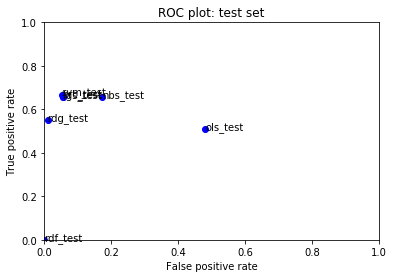

In [126]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [138]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='toxiccomments_test.csv', my_random_seed=99, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
the first 5 rows of data after cleaning comment texts:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC ==    The title is fine as it is, ...
2  00013b17ad2

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [162]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.15255543078007888


In [163]:
raw_data.head()

,id,comment_text,word_count,punc_count,new_line,exclam_count,question_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10,0,0,0
1,0000247867823ef7,"== From RfC == The title is fine as it is, ...",15,1,0,0,0
2,00013b17ad220c46,""" == Sources == * Zawe Ashton on Lapland...",20,0,0,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3,0,0,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1,0,0,0


In [164]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [142]:
my_submission.shape

(153164, 2)

In [143]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation